#  Well Production Simulation - Interactive Exploration

This notebook provides an interactive environment to explore and test well production simulations using the SimOxy Simulation Engine.

## Contents
1. [Setup & Imports](#1.-Setup-&-Imports)
2. [Load & Explore Data](#2.-Load-&-Explore-Data)
3. [Decline Curve Analysis](#3.-Decline-Curve-Analysis)
4. [Create & Run Simulation](#4.-Create-&-Run-Simulation)
5. [Production Visualization](#5.-Production-Visualization)
6. [Scenario Testing](#6.-Scenario-Testing)

---
## 1. Setup & Imports

In [1]:
# Standard library imports
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta
from typing import Dict, List, Any

# Data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Set up paths for simulation imports


# Configure display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(" Standard imports loaded")

 Standard imports loaded


In [2]:
# Import simulation modules
try:
    from simulation import SimulationRunner, BasinModel, WellAgent
    from simulation.agents import PipelineAgent, RefineryAgent
    from config.simulation_config import (
        WellType,
        DeclineType,
        DriveMechanism,
        WellConfiguration,
        WELL_TYPE_PARAMETERS,
        DRIVE_MECHANISM_DECLINE_MULTIPLIER,
        CONFIGURATION_MULTIPLIER,
        CONSTANTS,
    )
    print(" Simulation modules loaded successfully!")
    print(f"\n Available Well Types: {list(WellType)}")
    print(f" Available Decline Types: {list(DeclineType)}")
except ImportError as e:
    print(f" Import error: {e}")
    print("Make sure you're running from the correct directory.")

 Simulation modules loaded successfully!

 Available Well Types: [<WellType.SHALE_OIL: 'Shale Oil'>, <WellType.CONVENTIONAL_TIGHT: 'Conventional Tight'>, <WellType.CONVENTIONAL_ONSHORE: 'Conventional Onshore'>, <WellType.CONVENTIONAL_OFFSHORE: 'Conventional Offshore'>, <WellType.TIGHT: 'Tight'>, <WellType.CUSTOM: 'Custom'>]
 Available Decline Types: [<DeclineType.EXPONENTIAL: 'Exponential'>, <DeclineType.HYPERBOLIC: 'Hyperbolic'>, <DeclineType.HARMONIC: 'Harmonic'>]


---
## 2. Load & Explore Data

In [3]:
# Load b-factor data
b_factor_df = pd.read_csv( "data\\b_factor.csv")
print(" B-Factor Ranges by Well Type:")
display(b_factor_df)

 B-Factor Ranges by Well Type:


Well Type  Hyperbolic_b_Low  Hyperbolic_b_High  \
0  Conventional Offshore              0.20               0.50   
1   Conventional Onshore              0.30               0.60   
2                  Shale              0.80               1.30   
3     Conventional Tight              0.40               0.80   
4                  Tight              0.50               1.00   

   Exponential_b_Low  Exponential_b_High  Harmonic_b_Low  Harmonic_b_High  
0                  0                0.05            0.95             1.05  
1                  0                0.05            0.95             1.05  
2                  0                0.10            0.95             1.10  
3                  0                0.05            0.95             1.05  
4                  0                0.08            0.95             1.08

In [4]:
# Load average b-factors
b_factor_avg_df = pd.read_csv("data\\b_factor_avg.csv")
print(" Average B-Factor by Well Type and Model:")
pivot_df = b_factor_avg_df.pivot(index='well_type', columns='model', values='avg_value')
display(pivot_df)

 Average B-Factor by Well Type and Model:


model                  exponential  harmonic  hyperbolic
well_type                                               
CONVENTIONAL OFFSHORE         0.03      1.00        0.35
CONVENTIONAL ONSHORE          0.03      1.00        0.45
CONVENTIONAL TIGHT            0.03      1.00        0.60
SHALE                         0.05      1.02        1.05
TIGHT                         0.04      1.01        0.75

In [5]:
# Load reserves data
reserves_df = pd.read_csv(  "data\\reserves\\reserves.csv")
print(" Reserves Data:")
display(reserves_df)

# Extract key values
if not reserves_df.empty:
    row = reserves_df.iloc[0]
    print(f"\n Market Center: {row['market_center']}")
    print(f" Basin: {row['basin_name']}")
    print(f" Crude Recoverable: {row['crude_recoverable_pp_bbl']:,.0f} bbl")
    print(f" Crude Cumulative Produced: {row['crude_cumul_prod_bbl']:,.0f} bbl")
    print(f" Crude Remaining: {row['crude_remaining_pp_bbl']:,.0f} bbl")
    print(f" Recovery Rate: {row['crude_cumul_prod_bbl']/row['crude_recoverable_pp_bbl']*100:.1f}%")

 Reserves Data:


country market_center                            basin_name  \
0  United States       Houston  Houston Embayment (Gulf Coast Basin)   

  main_parent_basin_name  basin_sqkm  oil_recoverable_pp_bbl  \
0       Gulf Coast Basin  103,972.40              5889660000   

   cond_recoverable_pp_bbl  cumul_oil_prod_bbl  cumul_cond_prod_bbl  \
0                379910000          5748330000            367410000   

   oil_remaining_pp_bbl  cond_remaining_pp_bbl  crude_recoverable_pp_bbl  \
0             141330000               12500000                6269570000   

   crude_cumul_prod_bbl  crude_remaining_pp_bbl date_of_last_db_update  \
0            6115740000               153830000    2025-05-14 12:44:32   

  date_of_last_refresh  
0  2025-10-24 12:12:35


 Market Center: Houston
 Basin: Houston Embayment (Gulf Coast Basin)
 Crude Recoverable: 6,269,570,000 bbl
 Crude Cumulative Produced: 6,115,740,000 bbl
 Crude Remaining: 153,830,000 bbl
 Recovery Rate: 97.5%


 Crude Grade Distribution by Market Center:


market_center crude_quality  percentage
0                Permian   Light Sweet          90
1                Permian   Medium Sour          10
2                Cushing   Light Sweet          88
3                Cushing   Medium Sour          12
4                 Bakken   Light Sweet          96
5                 Bakken  Medium Sweet           3
6                 Bakken   Medium Sour           1
7                Rockies   Light Sweet          93
8                Rockies   Medium Sour           7
9   Louisiana Gulf Coast   Medium Sour          68
10  Louisiana Gulf Coast   Light Sweet          18
11  Louisiana Gulf Coast  Medium Sweet           6
12  Louisiana Gulf Coast    Light Sour           5
13  Louisiana Gulf Coast    Heavy Sour           3
14            Eagle Ford   Light Sweet          80
15            Eagle Ford   Medium Sour          20
16               Houston   Light Sweet          75
17               Houston   Medium Sour          20
18               Houston  Medium Sweet           3
19               Houston    Light Sour           1
20               Houston    Heavy Sour           1
21        Corpus Christi   Light Sweet          78
22        Corpus Christi   Medium Sour          19
23        Corpus Christi  Medium Sweet           2
24        Corpus Christi    Light Sour           1

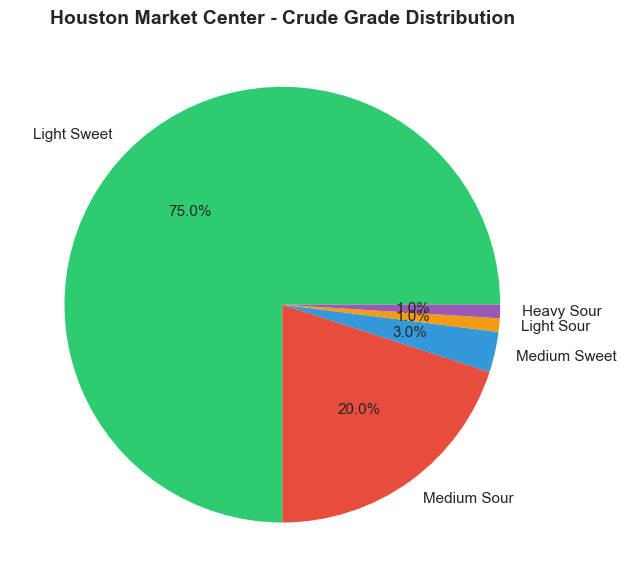

In [6]:
# Load grade data
grade_df = pd.read_csv("data\\grade\\grade_data.csv")
print(" Crude Grade Distribution by Market Center:")
display(grade_df)

# Visualize Houston grades
houston_grades = grade_df[grade_df['market_center'] == 'Houston']
if not houston_grades.empty:
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6']
    houston_grades.plot.pie(
        y='percentage', 
        labels=houston_grades['crude_quality'],
        autopct='%1.1f%%',
        colors=colors[:len(houston_grades)],
        ax=ax,
        legend=False
    )
    ax.set_ylabel('')
    ax.set_title('Houston Market Center - Crude Grade Distribution', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [7]:
# Load well dimension data (qi, di, b)
print(" Loading Well Dimension Data (qi_di_b_dimension.csv)...")
qi_di_df = pd.read_csv("data\\qi_di_b_factor_dimension.csv")
print(f"Total records: {len(qi_di_df):,}")
print(f"\nColumns: {list(qi_di_df.columns)}")
print(f"\nFirst 10 rows:")
display(qi_di_df.head(10))

 Loading Well Dimension Data (qi_di_b_dimension.csv)...
Total records: 17,209

Columns: ['country', 'market_id', 'basin_name', 'sub_basin_name', 'well_type', 'start_year', 'Qi', 'Di', 'model', 'b_factor']

First 10 rows:


country market_id       basin_name  \
0  UNITED STATES OF AMERICA       NaN              NaN   
1  UNITED STATES OF AMERICA       NaN              NaN   
2  UNITED STATES OF AMERICA       NaN              NaN   
3  UNITED STATES OF AMERICA       NaN              NaN   
4  UNITED STATES OF AMERICA   Cushing  AMARILLO UPLIFT   
5  UNITED STATES OF AMERICA   Cushing  AMARILLO UPLIFT   
6  UNITED STATES OF AMERICA   Cushing  AMARILLO UPLIFT   
7  UNITED STATES OF AMERICA   Cushing   ANADARKO BASIN   
8  UNITED STATES OF AMERICA   Cushing   ANADARKO BASIN   
9  UNITED STATES OF AMERICA   Cushing   ANADARKO BASIN   

                             sub_basin_name             well_type  start_year  \
0                                       NaN                   NaN        2024   
1                                       NaN  CONVENTIONAL ONSHORE        2024   
2                                       NaN  CONVENTIONAL ONSHORE        2024   
3                                       NaN  CONVENTIONAL ONSHORE        2024   
4                           AMARILLO UPLIFT  CONVENTIONAL ONSHORE        2024   
5                           AMARILLO UPLIFT  CONVENTIONAL ONSHORE        2024   
6                           AMARILLO UPLIFT  CONVENTIONAL ONSHORE        2024   
7  ANADARKO DEEP SUB-BASIN (ANADARKO BASIN)  CONVENTIONAL ONSHORE        2024   
8  ANADARKO DEEP SUB-BASIN (ANADARKO BASIN)  CONVENTIONAL ONSHORE        2024   
9  ANADARKO DEEP SUB-BASIN (ANADARKO BASIN)  CONVENTIONAL ONSHORE        2024   

         Qi   Di        model  b_factor  
0 10,530.00 0.86          NaN       NaN  
1  7,343.50 0.45   hyperbolic      0.45  
2  7,343.50 0.45  exponential      0.03  
3  7,343.50 0.45     harmonic      1.00  
4    674.50 1.61   hyperbolic      0.45  
5    674.50 1.61  exponential      0.03  
6    674.50 1.61     harmonic      1.00  
7  6,223.50 1.10   hyperbolic      0.45  
8  6,223.50 1.10  exponential      0.03  
9  6,223.50 1.10     harmonic      1.00

In [8]:
# Analyze well dimension statistics
print(" Well Parameter Statistics:")
numeric_cols = qi_di_df.select_dtypes(include=[np.number]).columns
display(qi_di_df[numeric_cols].describe())

 Well Parameter Statistics:


start_year         Qi        Di  b_factor
count   17,209.00  15,995.00 15,355.00 16,317.00
mean     2,011.48   4,824.86      0.74      0.56
std          6.99  19,029.83      0.95      0.42
min      2,000.00       0.25     -7.73      0.03
25%      2,006.00     177.00      0.27      0.04
50%      2,011.00     818.00      0.77      0.45
75%      2,017.00   2,868.75      1.24      1.00
max      2,024.00 584,590.00     10.20      1.05

---
## 3. Decline Curve Analysis

Understanding decline curves is essential for production forecasting. The simulation supports three types:
- **Exponential** (b = 0): Constant percentage decline
- **Hyperbolic** (0 < b < 1): Common for conventional wells
- **Harmonic** (b = 1): Slowest decline rate

In [9]:
def calculate_decline_curve(
    qi: float,           # Initial production (bbl/day)
    di: float,           # Nominal decline rate (per year)
    b: float,            # Decline exponent (0=exponential, 1=harmonic)
    days: int = 365*5    # Forecast period (days)
) -> pd.DataFrame:
    """
    Calculate production decline curve.
    
    Returns DataFrame with daily production forecast.
    """
    results = []
    
    for day in range(days):
        t_years = day / 365.0
        
        if b == 0:
            # Exponential decline
            q_t = qi * math.exp(-di * t_years)
        else:
            # Hyperbolic/Harmonic decline
            denom = 1 + (b * di * t_years)
            if denom <= 0:
                q_t = 0
            else:
                q_t = qi / (denom ** (1.0 / b))
        
        results.append({
            'day': day,
            'year': t_years,
            'production': max(0, q_t)
        })
    
    return pd.DataFrame(results)

print(" Decline curve function defined")

 Decline curve function defined


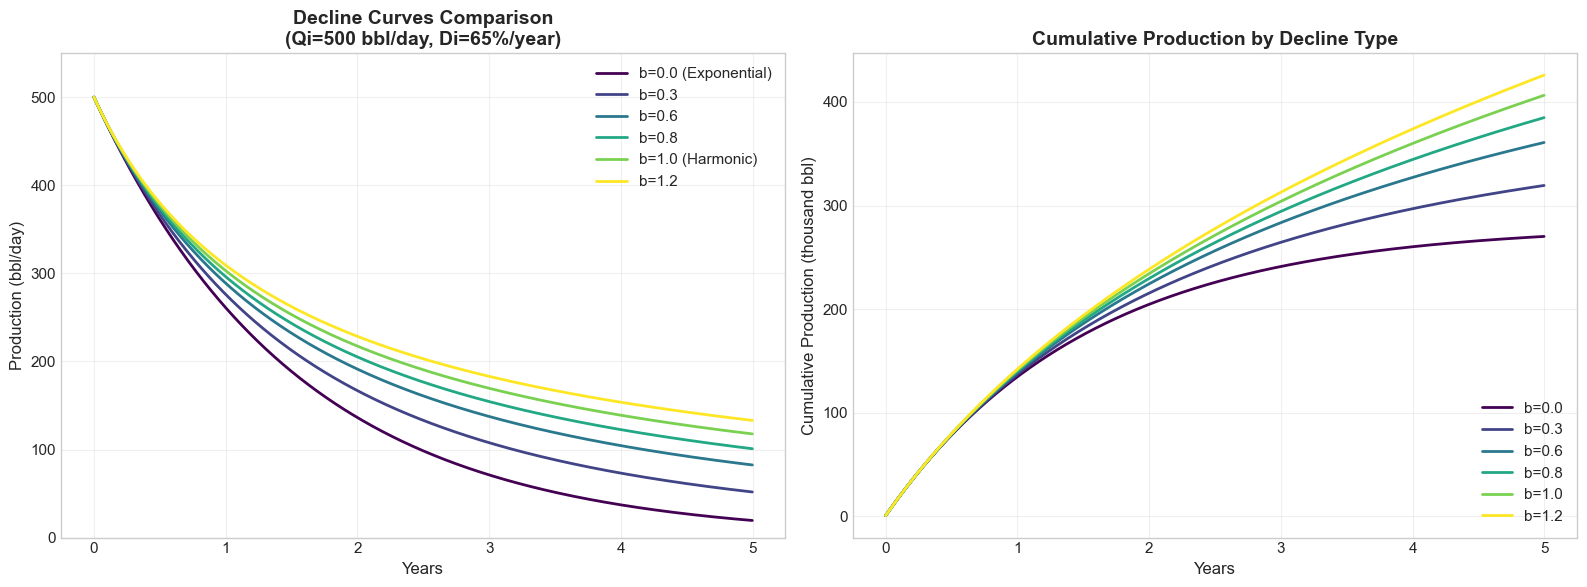


 Estimated Ultimate Recovery (EUR) after 5 years:
  b=0.0: 270,123 bbl (270.1k bbl)
  b=0.3: 319,364 bbl (319.4k bbl)
  b=0.6: 360,880 bbl (360.9k bbl)
  b=0.8: 384,882 bbl (384.9k bbl)
  b=1.0: 406,442 bbl (406.4k bbl)
  b=1.2: 425,921 bbl (425.9k bbl)


In [10]:
# Compare decline curves for different b-factors
qi = 500  # Initial production: 500 bbl/day
di = 0.65  # 65% annual decline rate
forecast_years = 5

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Different b-factors
b_values = [0, 0.3, 0.6, 0.8, 1.0, 1.2]
colors = plt.cm.viridis(np.linspace(0, 1, len(b_values)))

ax1 = axes[0]
for b, color in zip(b_values, colors):
    df = calculate_decline_curve(qi, di, b, days=365*forecast_years)
    label = f'b={b:.1f}' + (' (Exponential)' if b == 0 else ' (Harmonic)' if b == 1 else '')
    ax1.plot(df['year'], df['production'], label=label, color=color, linewidth=2)

ax1.set_xlabel('Years', fontsize=12)
ax1.set_ylabel('Production (bbl/day)', fontsize=12)
ax1.set_title(f'Decline Curves Comparison\n(Qi={qi} bbl/day, Di={di*100:.0f}%/year)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.set_ylim(0, qi * 1.1)
ax1.grid(True, alpha=0.3)

# Cumulative production
ax2 = axes[1]
for b, color in zip(b_values, colors):
    df = calculate_decline_curve(qi, di, b, days=365*forecast_years)
    df['cumulative'] = df['production'].cumsum()
    label = f'b={b:.1f}'
    ax2.plot(df['year'], df['cumulative'] / 1000, label=label, color=color, linewidth=2)

ax2.set_xlabel('Years', fontsize=12)
ax2.set_ylabel('Cumulative Production (thousand bbl)', fontsize=12)
ax2.set_title('Cumulative Production by Decline Type', fontsize=14, fontweight='bold')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print EUR for each b-factor
print(f"\n Estimated Ultimate Recovery (EUR) after {forecast_years} years:")
print("=" * 50)
for b in b_values:
    df = calculate_decline_curve(qi, di, b, days=365*forecast_years)
    eur = df['production'].sum()
    print(f"  b={b:.1f}: {eur:,.0f} bbl ({eur/1000:.1f}k bbl)")

In [11]:
# Compare well types with their typical parameters
print(" Well Type Parameter Comparison:")
print("=" * 80)

well_type_data = []
for wt, params in WELL_TYPE_PARAMETERS.items():
    well_type_data.append({
        'Well Type': wt,
        'Typical Qi (bbl/day)': params.get('typical_qi', 'N/A'),
        'Decline Exponent (b)': params.get('decline_exponent', 'N/A'),
        'Nominal Decline Rate': params.get('nominal_decline_rate', 'N/A'),
        'Max Capacity Multiplier': params.get('default_max_capacity_multiplier', 'N/A')
    })

wt_df = pd.DataFrame(well_type_data)
display(wt_df)

 Well Type Parameter Comparison:


Well Type  Typical Qi (bbl/day)  Decline Exponent (b)  \
0              Shale Oil                   500                  1.30   
1     Conventional Tight                   150                  0.95   
2   Conventional Onshore                    26                  0.40   
3  Conventional Offshore                   100                  0.60   
4                  Tight                   200                  1.00   
5                 Custom                   250                  0.50   

   Nominal Decline Rate  Max Capacity Multiplier  
0                  0.65                     3.00  
1                  0.32                     2.00  
2                  0.15                    15.00  
3                  0.14                     8.00  
4                  0.30                     4.00  
5                  0.20                     5.00

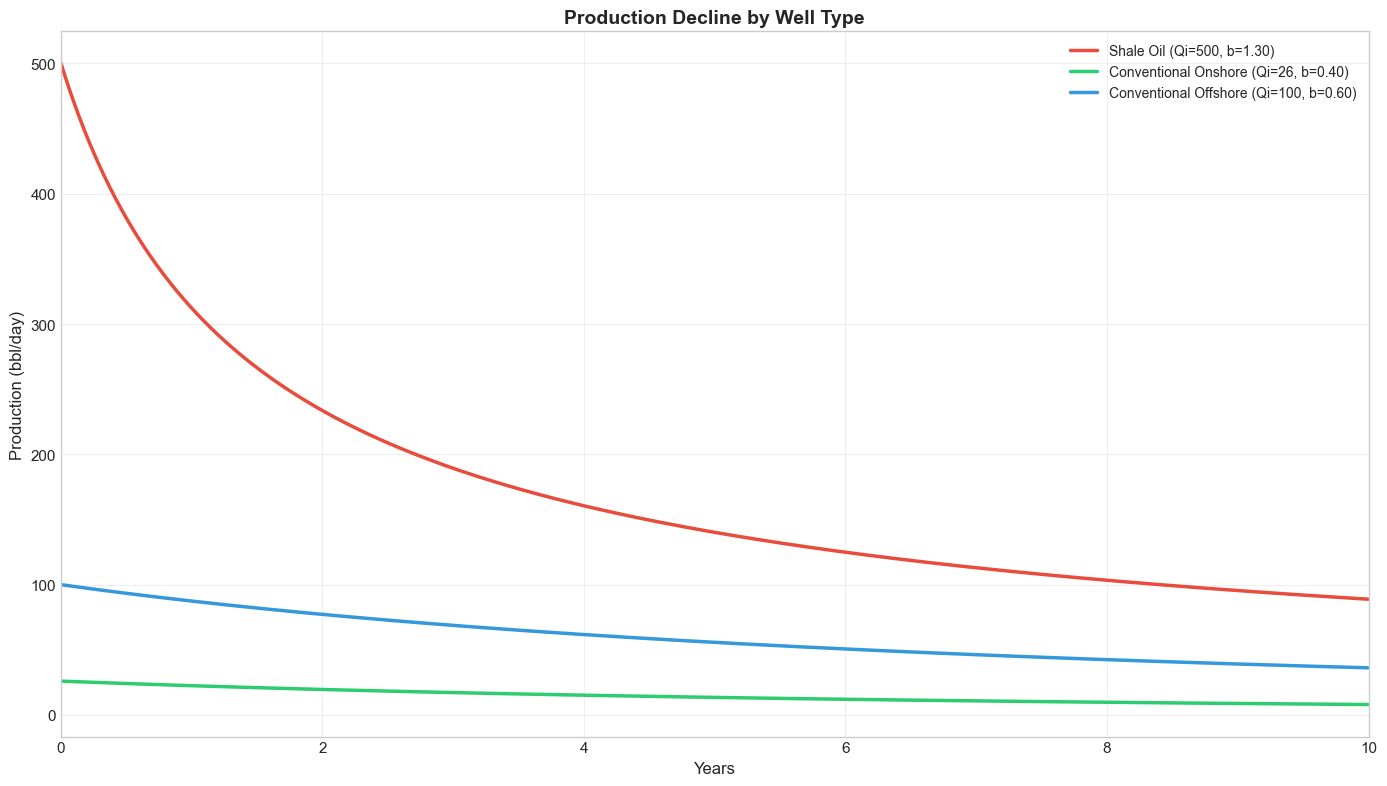

In [12]:
# Visualize decline curves for different well types
fig, ax = plt.subplots(figsize=(14, 8))

well_types_to_plot = ['Shale Oil', 'Conventional Onshore', 'Conventional Offshore', 'Tight Oil']
colors = ['#e74c3c', '#2ecc71', '#3498db', '#9b59b6']
forecast_years = 10

for wt, color in zip(well_types_to_plot, colors):
    if wt in WELL_TYPE_PARAMETERS:
        params = WELL_TYPE_PARAMETERS[wt]
        qi = params.get('typical_qi', 100)
        b = params.get('decline_exponent', 0.5)
        di = params.get('nominal_decline_rate', 0.3)
        
        df = calculate_decline_curve(qi, di, b, days=365*forecast_years)
        ax.plot(df['year'], df['production'], label=f'{wt} (Qi={qi}, b={b:.2f})', 
                color=color, linewidth=2.5)

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Production (bbl/day)', fontsize=12)
ax.set_title('Production Decline by Well Type', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(0, forecast_years)

plt.tight_layout()
plt.show()

---
## 4. Create & Run Simulation

Now let's create an actual simulation with the BasinModel and WellAgents.

In [13]:
# Define simulation parameters
SIM_CONFIG = {
    'start_date': datetime(2025, 1, 1),
    'end_date': datetime(2025, 12, 31),  # 1 year simulation
    'basin_name': 'Houston Embayment (Gulf Coast Basin)',
    'market_center': 'Houston',
    'country': 'US',
    'total_recoverable_resources': 6_269_570_000,  # From reserves.csv
}

print(" Simulation Configuration:")
print("=" * 50)
for key, value in SIM_CONFIG.items():
    if isinstance(value, (int, float)) and value > 1000:
        print(f"  {key}: {value:,.0f}")
    else:
        print(f"  {key}: {value}")

 Simulation Configuration:
  start_date: 2025-01-01 00:00:00
  end_date: 2025-12-31 00:00:00
  basin_name: Houston Embayment (Gulf Coast Basin)
  market_center: Houston
  country: US
  total_recoverable_resources: 6,269,570,000


In [14]:
# Create the simulation runner
runner = SimulationRunner(
    total_recoverable_resources=SIM_CONFIG['total_recoverable_resources'],
    start_date=SIM_CONFIG['start_date'],
    end_date=SIM_CONFIG['end_date'],
    basin_name=SIM_CONFIG['basin_name'],
    market_center=SIM_CONFIG['market_center'],
    country=SIM_CONFIG['country'],
)

print(" SimulationRunner created!")
print(f"\n Summary:")
summary = runner.get_summary()
for key, value in summary.items():
    if isinstance(value, (int, float)) and value is not None and abs(value) > 1000:
        print(f"  {key}: {value:,.0f}")
    else:
        print(f"  {key}: {value}")

No reserves data available for market_center='Houston'. Reserves tracking disabled.


 SimulationRunner created!

 Summary:
  basin_name: Houston Embayment (Gulf Coast Basin)
  country: US
  market_center: Houston
  start_date: 2025-01-01 00:00:00
  end_date: 2025-12-31 00:00:00
  total_recoverable_resources: None
  remaining_reserves: None
  cumulative_production: 0.0
  recovery_factor: None
  num_wells: 0


In [15]:
# Define sample wells
SAMPLE_WELLS = [
    {
        'name': 'Shale Well A',
        'well_type': 'Shale Oil',
        'initial_production': 800,  # bbl/day
        'b_factor': 1.1,
        'nominal_decline_rate': 0.75,
        'decline_type': 'Hyperbolic',
        'location': 'Gulf Coast Basin',
        'basin': 'Houston Embayment',
        'production_start_date': datetime(2025, 1, 1),
    },
    {
        'name': 'Conventional Well B',
        'well_type': 'Conventional Onshore',
        'initial_production': 200,  # bbl/day
        'b_factor': 0.4,
        'nominal_decline_rate': 0.15,
        'decline_type': 'Hyperbolic',
        'location': 'Gulf Coast Basin',
        'basin': 'Houston Embayment',
        'production_start_date': datetime(2025, 1, 1),
    },
    {
        'name': 'Tight Oil Well C',
        'well_type': 'Tight Oil',
        'initial_production': 400,  # bbl/day
        'b_factor': 0.8,
        'nominal_decline_rate': 0.55,
        'decline_type': 'Hyperbolic',
        'location': 'Gulf Coast Basin',
        'basin': 'Houston Embayment',
        'production_start_date': datetime(2025, 1, 15),  # Starts mid-January
    },
    {
        'name': 'Offshore Well D',
        'well_type': 'Conventional Offshore',
        'initial_production': 1500,  # bbl/day
        'b_factor': 0.35,
        'nominal_decline_rate': 0.12,
        'decline_type': 'Hyperbolic',
        'location': 'Offshore Gulf of Mexico',
        'basin': 'Deep Water Gulf of Mexico',
        'production_start_date': datetime(2025, 2, 1),  # Starts in February
    },
]

print(f"📝 Defined {len(SAMPLE_WELLS)} sample wells:")
for i, well in enumerate(SAMPLE_WELLS, 1):
    print(f"  {i}. {well['name']} - {well['well_type']} (Qi={well['initial_production']} bbl/day)")

📝 Defined 4 sample wells:
  1. Shale Well A - Shale Oil (Qi=800 bbl/day)
  2. Conventional Well B - Conventional Onshore (Qi=200 bbl/day)
  3. Tight Oil Well C - Tight Oil (Qi=400 bbl/day)
  4. Offshore Well D - Conventional Offshore (Qi=1500 bbl/day)


In [16]:
# Add wells to simulation
print("➕ Adding wells to simulation...")
print("=" * 60)

added_wells = []
for well_config in SAMPLE_WELLS:
    # Remove 'name' as it's not a WellAgent parameter
    name = well_config.pop('name')
    
    try:
        well_state = runner.add_well(**well_config)
        added_wells.append({'name': name, 'state': well_state})
        print(f"   {name} added (ID: {well_state['id']})")
    except Exception as e:
        print(f"   {name} failed: {e}")
    
    # Restore name for later reference
    well_config['name'] = name

print(f"\n Total wells in simulation: {runner.count_wells_in_simulation_range()}")

➕ Adding wells to simulation...
   Shale Well A added (ID: 2)
   Conventional Well B added (ID: 3)
   Tight Oil Well C failed: Unsupported well_type: Tight Oil. Valid types: ['Conventional Offshore', 'Conventional Onshore', 'Conventional Tight', 'Custom', 'Shale Oil', 'Tight']
   Offshore Well D added (ID: 4)

 Total wells in simulation: 3


In [17]:
# Run the simulation
print(" Running simulation...")
print("=" * 60)

# Store daily results
daily_results = []

# Run simulation day by day
runner.start()
step_count = 0
total_steps = runner.total_steps

while runner.model.simulation_active:
    state = runner.step()
    step_count += 1
    
    # Extract production data
    sim_state = state['state']
    daily_results.append({
        'date': sim_state['current_date'],
        'total_daily_production': sum(w['daily_production'] for w in sim_state['basin']['wells']),
        'total_potential_production': sum(w['daily_potential_production'] for w in sim_state['basin']['wells']),
        'active_wells': sum(1 for w in sim_state['basin']['wells'] if w['is_active']),
        'cumulative_production': sim_state['basin']['cumulative_production'],
        'pipeline_utilization': sim_state['pipeline'].get('utilization_pct', 0),
    })
    
    # Progress update every 30 days
    if step_count % 30 == 0:
        progress = state['progress']['percentage']
        print(f"  Day {step_count}: {progress:.1f}% complete, "
              f"Daily prod: {daily_results[-1]['total_daily_production']:,.0f} bbl")

print(f"\n Simulation complete! Ran {step_count} days.")

 Running simulation...
  Day 30: 8.2% complete, Daily prod: 951 bbl

📊 MONTHLY PRODUCTION BY GRADE - January 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):        24,020.30 bbl
   Light Sweet (lSweet):        6,159.51 bbl
   ────────────────────────────────────────
   TOTAL:                      30,179.80 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):       41,800.76 bbl
   Light Sour  (lSour):        20,498.77 bbl
   Light Sweet (lSweet):        5,496.75 bbl
   ────────────────────────────────────────
   TOTAL:                      67,796.28 bbl

  Day 60: 16.5% complete, Daily prod: 2,394 bbl

📊 MONTHLY PRODUCTI

In [18]:
# Convert results to DataFrame
results_df = pd.DataFrame(daily_results)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df.set_index('date', inplace=True)

print(" Simulation Results Summary:")
print("=" * 60)
print(f"Total days simulated: {len(results_df)}")
print(f"Total production: {results_df['total_daily_production'].sum():,.0f} bbl")
print(f"Average daily production: {results_df['total_daily_production'].mean():,.0f} bbl/day")
print(f"Peak daily production: {results_df['total_daily_production'].max():,.0f} bbl/day")
print(f"\nFirst 10 days:")
display(results_df.head(10))

 Simulation Results Summary:
Total days simulated: 364
Total production: 759,341 bbl
Average daily production: 2,086 bbl/day
Peak daily production: 2,448 bbl/day

First 10 days:


total_daily_production  total_potential_production  active_wells  \
date                                                                           
2025-01-02                  998.28                      998.28             2   
2025-01-03                  996.56                      996.56             2   
2025-01-04                  994.86                      994.86             2   
2025-01-05                  993.16                      993.16             2   
2025-01-06                  991.46                      991.46             2   
2025-01-07                  989.78                      989.78             2   
2025-01-08                  988.10                      988.10             2   
2025-01-09                  986.43                      986.43             2   
2025-01-10                  984.76                      984.76             2   
2025-01-11                  983.10                      983.10             2   

            cumulative_production  pipeline_utilization  
date                                                     
2025-01-02                 998.28                  4.99  
2025-01-03               1,994.84                  4.98  
2025-01-04               2,989.70                  4.97  
2025-01-05               3,982.86                  4.97  
2025-01-06               4,974.32                  4.96  
2025-01-07               5,964.10                  4.95  
2025-01-08               6,952.20                  4.94  
2025-01-09               7,938.62                  4.93  
2025-01-10               8,923.38                  4.92  
2025-01-11               9,906.48                  4.92

---
## 5. Production Visualization

C:\Users\bhargavesh.dakka\AppData\Local\Temp\ipykernel_27356\2994793275.py:42: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prod = results_df['total_daily_production'].resample('M').sum()


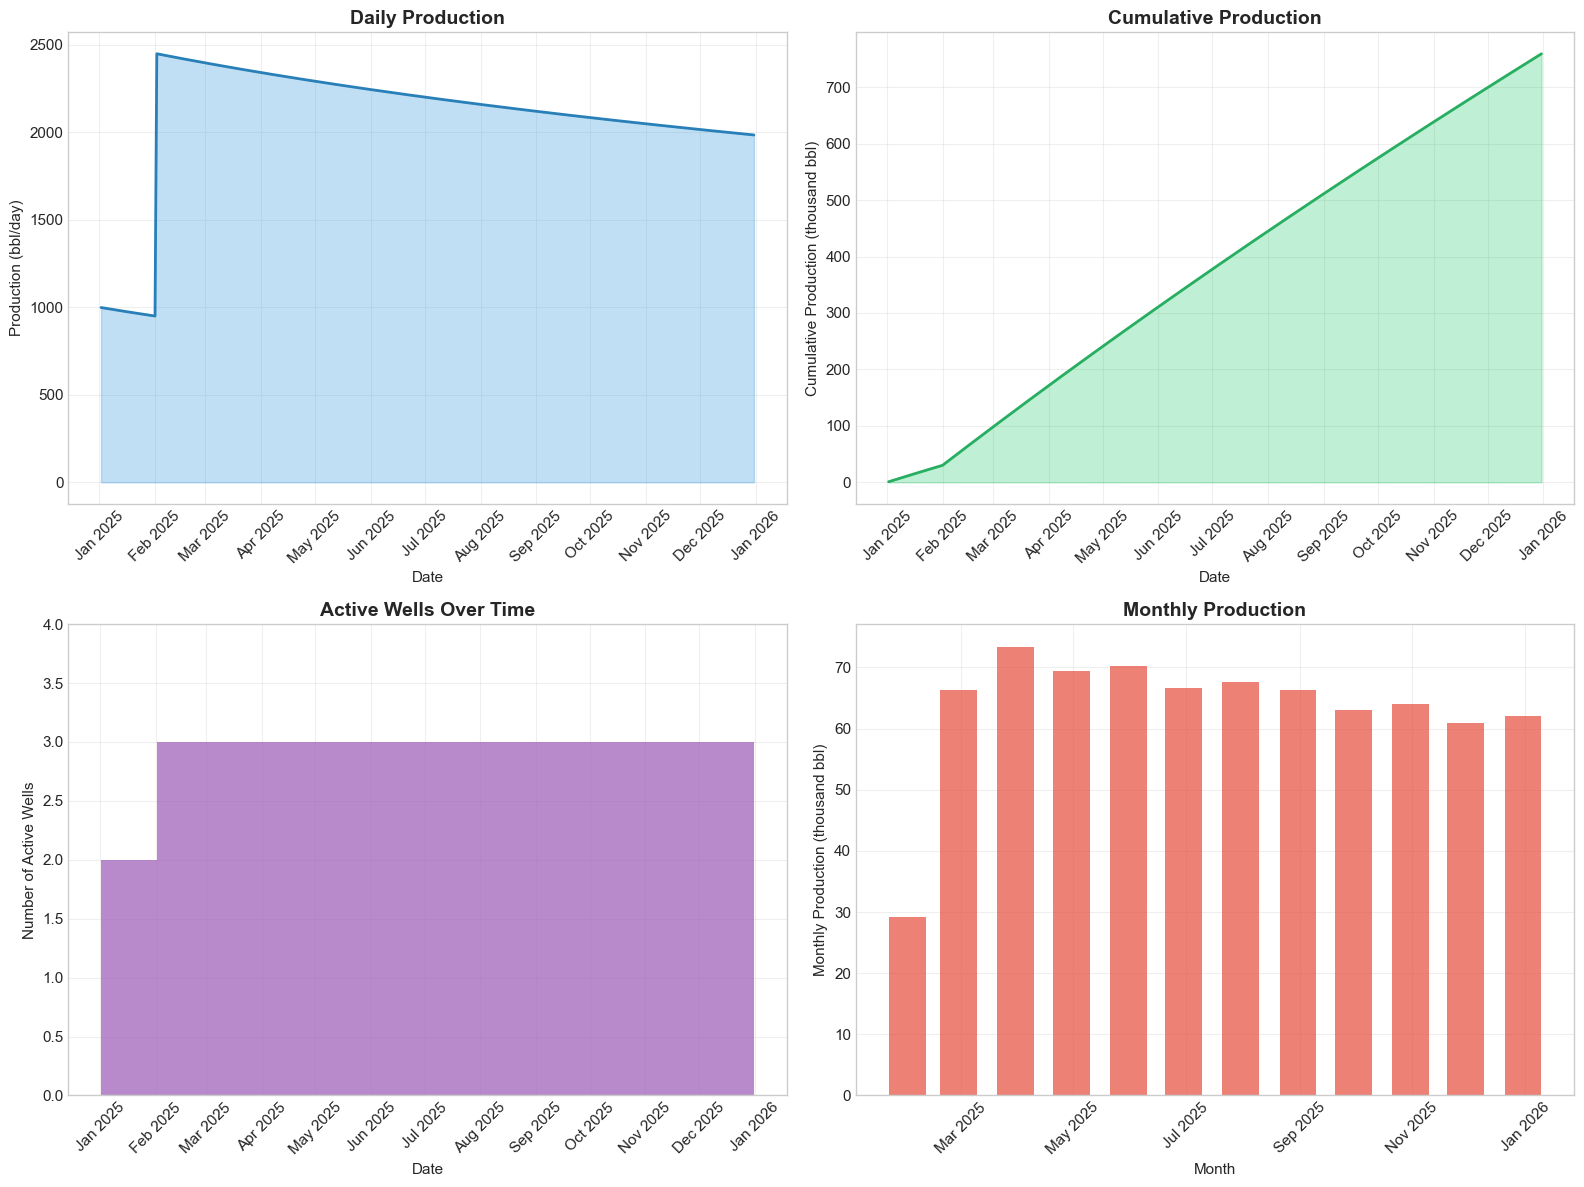

In [19]:
# Daily production plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Daily Production
ax1 = axes[0, 0]
ax1.fill_between(results_df.index, results_df['total_daily_production'], alpha=0.3, color='#3498db')
ax1.plot(results_df.index, results_df['total_daily_production'], color='#2980b9', linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Production (bbl/day)')
ax1.set_title('Daily Production', fontsize=14, fontweight='bold')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax1.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax1.grid(True, alpha=0.3)

# 2. Cumulative Production
ax2 = axes[0, 1]
ax2.fill_between(results_df.index, results_df['cumulative_production'] / 1000, alpha=0.3, color='#2ecc71')
ax2.plot(results_df.index, results_df['cumulative_production'] / 1000, color='#27ae60', linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Production (thousand bbl)')
ax2.set_title('Cumulative Production', fontsize=14, fontweight='bold')
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax2.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.grid(True, alpha=0.3)

# 3. Active Wells
ax3 = axes[1, 0]
ax3.bar(results_df.index, results_df['active_wells'], color='#9b59b6', alpha=0.7, width=1)
ax3.set_xlabel('Date')
ax3.set_ylabel('Number of Active Wells')
ax3.set_title('Active Wells Over Time', fontsize=14, fontweight='bold')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
ax3.xaxis.set_major_locator(mdates.MonthLocator())
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, max(results_df['active_wells']) + 1)

# 4. Monthly Production
ax4 = axes[1, 1]
monthly_prod = results_df['total_daily_production'].resample('M').sum()
bars = ax4.bar(monthly_prod.index, monthly_prod.values / 1000, color='#e74c3c', alpha=0.7, width=20)
ax4.set_xlabel('Month')
ax4.set_ylabel('Monthly Production (thousand bbl)')
ax4.set_title('Monthly Production', fontsize=14, fontweight='bold')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Get individual well production from final state
final_state = runner.get_state()['state']
wells_data = final_state['basin']['wells']

print(" Final Well Status:")
print("=" * 80)

well_summary = []
for well in wells_data:
    well_summary.append({
        'ID': well['id'],
        'Type': well['well_type'],
        'Status': well['status'],
        'Initial Qi (bbl/day)': well['initial_production'],
        'Current (bbl/day)': well['daily_production'],
        'Cumulative (bbl)': well['cumulative_production'],
        'EUR (bbl)': well['eur'],
        'Recovery %': well['recovery_percentage'],
        'Days On': well['days_on_production'],
    })

well_summary_df = pd.DataFrame(well_summary)
display(well_summary_df)

 Final Well Status:


ID                   Type  Status  Initial Qi (bbl/day)  Current (bbl/day)  \
0   2              Shale Oil  Active                800.00             463.65   
1   3   Conventional Onshore  Active                200.00             172.97   
2   4  Conventional Offshore  Active              1,500.00           1,347.30   

   Cumulative (bbl)    EUR (bbl)  Recovery %  Days On  
0        218,255.40 1,338,812.83       16.30      364  
1         67,700.80   638,514.42       10.60      364  
2        473,385.22 5,479,541.32        8.64      333

In [21]:
# Visualize well contributions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart of cumulative production by well
ax1 = axes[0]
cumulative_by_well = well_summary_df.set_index('ID')['Cumulative (bbl)']
colors = plt.cm.Set3(np.linspace(0, 1, len(cumulative_by_well)))
wedges, texts, autotexts = ax1.pie(
    cumulative_by_well, 
    labels=[f"Well {id}" for id in cumulative_by_well.index],
    autopct='%1.1f%%',
    colors=colors,
    explode=[0.02] * len(cumulative_by_well)
)
ax1.set_title('Production Share by Well', fontsize=14, fontweight='bold')

# Bar chart of recovery percentage
ax2 = axes[1]
x = range(len(well_summary_df))
bars = ax2.bar(x, well_summary_df['Recovery %'], color=colors, edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Well ID')
ax2.set_ylabel('Recovery Percentage (%)')
ax2.set_title('EUR Recovery Progress', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels([f"Well {id}\n({row['Type'][:10]}...)" for id, row in well_summary_df.iterrows()], rotation=0)
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars, well_summary_df['Recovery %']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

---
## 6. Scenario Testing

Let's test different scenarios to understand how various parameters affect production.

In [22]:
def run_scenario(
    wells_config: List[Dict],
    start_date: datetime,
    end_date: datetime,
    scenario_name: str = "Scenario"
) -> pd.DataFrame:
    """
    Run a simulation scenario and return daily results.
    """
    # Create new runner
    scenario_runner = SimulationRunner(
        total_recoverable_resources=6_269_570_000,
        start_date=start_date,
        end_date=end_date,
        basin_name='Houston Embayment',
        market_center='Houston',
        country='US',
    )
    
    # Add wells
    for well_config in wells_config:
        config = dict(well_config)  # Copy to avoid modifying original
        config.pop('name', None)
        scenario_runner.add_well(**config)
    
    # Run simulation
    scenario_runner.start()
    results = []
    
    while scenario_runner.model.simulation_active:
        state = scenario_runner.step()
        sim_state = state['state']
        results.append({
            'date': sim_state['current_date'],
            'daily_production': sum(w['daily_production'] for w in sim_state['basin']['wells']),
            'cumulative': sim_state['basin']['cumulative_production'],
        })
    
    df = pd.DataFrame(results)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df['scenario'] = scenario_name
    
    return df

print(" Scenario testing function defined")

 Scenario testing function defined


In [23]:
# Scenario 1: Compare different well types
print(" Running Well Type Comparison Scenarios...")
print("=" * 60)

scenarios = {}
start = datetime(2025, 1, 1)
end = datetime(2025, 12, 31)

# Scenario: 4 Shale wells
shale_wells = [
    {'well_type': 'Shale Oil', 'initial_production': 500, 'b_factor': 1.0, 
     'nominal_decline_rate': 0.7, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start}
    for _ in range(4)
]
scenarios['Shale (4 wells)'] = run_scenario(shale_wells, start, end, 'Shale')
print("   Shale scenario complete")

# Scenario: 4 Conventional wells
conv_wells = [
    {'well_type': 'Conventional Onshore', 'initial_production': 150, 'b_factor': 0.4, 
     'nominal_decline_rate': 0.15, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start}
    for _ in range(4)
]
scenarios['Conventional (4 wells)'] = run_scenario(conv_wells, start, end, 'Conventional')
print("   Conventional scenario complete")

# Scenario: Mixed portfolio
mixed_wells = [
    {'well_type': 'Shale Oil', 'initial_production': 500, 'b_factor': 1.0, 
     'nominal_decline_rate': 0.7, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start},
    {'well_type': 'Shale Oil', 'initial_production': 500, 'b_factor': 1.0, 
     'nominal_decline_rate': 0.7, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start},
    {'well_type': 'Conventional Onshore', 'initial_production': 150, 'b_factor': 0.4, 
     'nominal_decline_rate': 0.15, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start},
    {'well_type': 'Conventional Onshore', 'initial_production': 150, 'b_factor': 0.4, 
     'nominal_decline_rate': 0.15, 'decline_type': 'Hyperbolic',
     'location': 'Gulf Coast', 'basin': 'Houston', 'production_start_date': start},
]
scenarios['Mixed Portfolio'] = run_scenario(mixed_wells, start, end, 'Mixed')
print("   Mixed portfolio scenario complete")

print("\n Scenario Summary:")

No reserves data available for market_center='Houston'. Reserves tracking disabled.
No reserves data available for market_center='Houston'. Reserves tracking disabled.
No reserves data available for market_center='Houston'. Reserves tracking disabled.


 Running Well Type Comparison Scenarios...

📊 MONTHLY PRODUCTION BY GRADE - January 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       60,172.05 bbl
   ────────────────────────────────────────
   TOTAL:                      60,172.05 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       51,518.88 bbl
   ────────────────────────────────────────
   TOTAL:                      51,518.88 bbl


📊 MONTHLY PRODUCTION BY GRADE - March 2025
   Market Center: Houston
   Heavy Sour  (hSour)

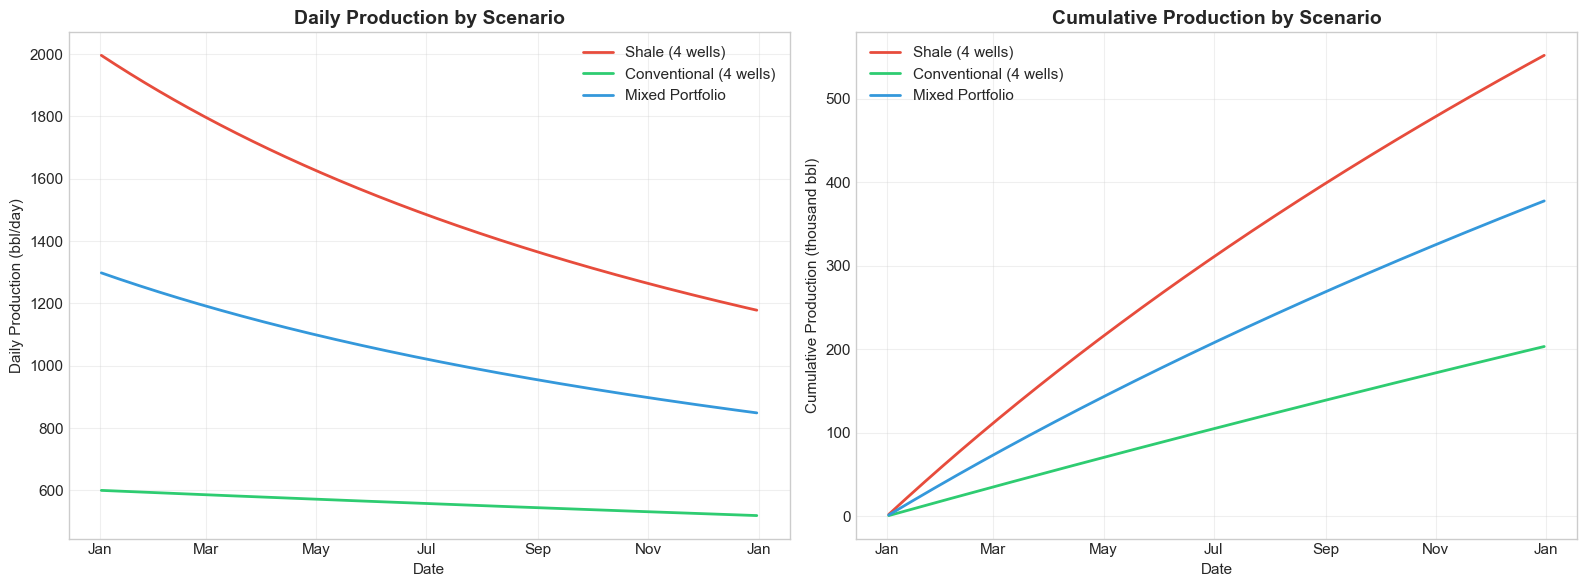


 Annual Production by Scenario:
  Shale (4 wells): 551,866 bbl (551.9k bbl)
  Conventional (4 wells): 203,102 bbl (203.1k bbl)
  Mixed Portfolio: 377,484 bbl (377.5k bbl)


In [24]:
# Visualize scenario comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors = {'Shale (4 wells)': '#e74c3c', 'Conventional (4 wells)': '#2ecc71', 'Mixed Portfolio': '#3498db'}

# Daily production comparison
ax1 = axes[0]
for name, df in scenarios.items():
    ax1.plot(df.index, df['daily_production'], label=name, color=colors[name], linewidth=2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Production (bbl/day)')
ax1.set_title('Daily Production by Scenario', fontsize=14, fontweight='bold')
ax1.legend()
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax1.grid(True, alpha=0.3)

# Cumulative production comparison
ax2 = axes[1]
for name, df in scenarios.items():
    ax2.plot(df.index, df['cumulative'] / 1000, label=name, color=colors[name], linewidth=2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Cumulative Production (thousand bbl)')
ax2.set_title('Cumulative Production by Scenario', fontsize=14, fontweight='bold')
ax2.legend()
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print totals
print("\n Annual Production by Scenario:")
print("=" * 50)
for name, df in scenarios.items():
    total = df['daily_production'].sum()
    print(f"  {name}: {total:,.0f} bbl ({total/1000:.1f}k bbl)")

No reserves data available for market_center='Houston'. Reserves tracking disabled.
No reserves data available for market_center='Houston'. Reserves tracking disabled.
No reserves data available for market_center='Houston'. Reserves tracking disabled.
No reserves data available for market_center='Houston'. Reserves tracking disabled.


🔬 Running Decline Rate Sensitivity Analysis...

📊 MONTHLY PRODUCTION BY GRADE - January 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       15,299.75 bbl
   ────────────────────────────────────────
   TOTAL:                      15,299.75 bbl


📊 MONTHLY PRODUCTION BY GRADE - February 2025
   Market Center: Houston
   Heavy Sour  (hSour):             0.00 bbl
   Heavy Sweet (hSweet):            0.00 bbl
   Medium Sour (mSour):             0.00 bbl
   Medium Sweet(mSweet):            0.00 bbl
   Light Sour  (lSour):             0.00 bbl
   Light Sweet (lSweet):       13,496.20 bbl
   ────────────────────────────────────────
   TOTAL:                      13,496.20 bbl


📊 MONTHLY PRODUCTION BY GRADE - March 2025
   Market Center: Houston
   Heavy Sour  (hS

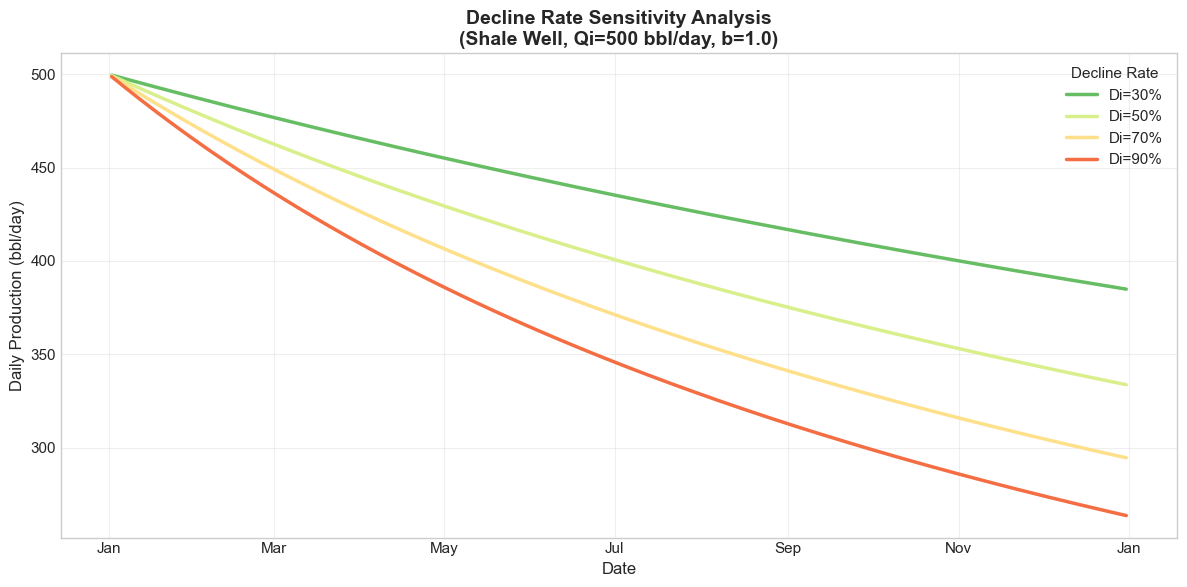


 Annual Production by Decline Rate:
  Di=30%: 159,176 bbl (159.2k bbl)
  Di=50%: 147,596 bbl (147.6k bbl)
  Di=70%: 137,967 bbl (138.0k bbl)
  Di=90%: 129,796 bbl (129.8k bbl)


In [25]:
# Scenario 2: Decline rate sensitivity analysis
print("🔬 Running Decline Rate Sensitivity Analysis...")
print("=" * 60)

decline_scenarios = {}
decline_rates = [0.3, 0.5, 0.7, 0.9]

for di in decline_rates:
    wells = [{
        'well_type': 'Shale Oil', 
        'initial_production': 500, 
        'b_factor': 1.0, 
        'nominal_decline_rate': di, 
        'decline_type': 'Hyperbolic',
        'location': 'Gulf Coast', 
        'basin': 'Houston', 
        'production_start_date': start
    }]
    decline_scenarios[f'Di={di*100:.0f}%'] = run_scenario(wells, start, end, f'Di={di}')
    print(f"   Di={di*100:.0f}% scenario complete")

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
colors = plt.cm.RdYlGn(np.linspace(0.8, 0.2, len(decline_rates)))

for (name, df), color in zip(decline_scenarios.items(), colors):
    ax.plot(df.index, df['daily_production'], label=name, color=color, linewidth=2.5)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Daily Production (bbl/day)', fontsize=12)
ax.set_title('Decline Rate Sensitivity Analysis\n(Shale Well, Qi=500 bbl/day, b=1.0)', fontsize=14, fontweight='bold')
ax.legend(title='Decline Rate')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Annual Production by Decline Rate:")
print("=" * 50)
for name, df in decline_scenarios.items():
    total = df['daily_production'].sum()
    print(f"  {name}: {total:,.0f} bbl ({total/1000:.1f}k bbl)")